**Audio Engagement Project EDA**
--

**Structure**
--
1. Overview
2. Data Collection
3. Descriptive Statistics
4. Handling Outliers
5. Feature Scaling
6. Data Visualization and Correlation Analysis
7. General Observations and Summary

**1. Overview**
--

The goal is to predict how long a user will listen to an audio episode, based on a range of feature data describing both the listener and the audio content.

The dataset was synthetically generated based on real-world user audio consumption patterns. Feature distributions are realistic but not identical to any publicly available dataset.

**train.csv** - the training dataset; `Listening_Time_minutes` is the target variable

**test.csv** - the test dataset; your objective is to predict the `Listening_Time_minutes` for each row

**sample_submission.csv** - a sample submission file in the correct format.

**2. Data Collection**
--

**Import Data and Required Packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle
import os
import zipfile
import time
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler
import statistics

**Import the DataSet**

In [2]:
kaggle.api.authenticate()
kaggle.api.competition_download_files('audio-engagement-challenge', path='data')

In [3]:
path_to_zip_file = "data/audio-engagement-challenge.zip"
dir_to_extract="data/"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(dir_to_extract)

**File information**

In [4]:
print(kaggle.api.competition_list_files('audio-engagement-challenge').files)

[{"ref": "", "name": "sample_submission.csv", "description": "", "totalBytes": 3500026, "url": "", "creationDate": "2025-10-11T12:36:50.840Z"}, {"ref": "", "name": "test.csv", "description": "", "totalBytes": 21277250, "url": "", "creationDate": "2025-10-11T12:36:50.840Z"}, {"ref": "", "name": "train.csv", "description": "", "totalBytes": 70036578, "url": "", "creationDate": "2025-10-11T12:36:50.840Z"}]


**Import the CSV Data as Pandas DataFrame**

In [5]:
start = time.time()
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")
print("Files loaded in", time.time()-start, "seconds")

Files loaded in 2.316704511642456 seconds


**3. Descriptive Statistics**
--

In [6]:
print("Shape of the training dataset:", train.shape)
print("Shape of the testing dataset:", test.shape)
print("Shape of the sample submission dataset:", sample_submission.shape)

Shape of the training dataset: (750000, 12)
Shape of the testing dataset: (250000, 11)
Shape of the sample submission dataset: (250000, 2)


In [7]:
print("Range of indexes of the training dataset:", train.index)
print("Range of indexes of the testing dataset:", test.index)
print("Range of indexes of the sample submission dataset:", sample_submission.index)

Range of indexes of the training dataset: RangeIndex(start=0, stop=750000, step=1)
Range of indexes of the testing dataset: RangeIndex(start=0, stop=250000, step=1)
Range of indexes of the sample submission dataset: RangeIndex(start=0, stop=250000, step=1)


In [8]:
print("Columns of the training dataset:",train.columns)
print("Columns of the testing dataset:",test.columns)
print("Columns of the sample submission dataset:",sample_submission.columns)

Columns of the training dataset: Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment', 'Listening_Time_minutes'],
      dtype='object')
Columns of the testing dataset: Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment'],
      dtype='object')
Columns of the sample submission dataset: Index(['id', 'Listening_Time_minutes'], dtype='object')


In [9]:
train.info()
test.info()
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


**Show top 5 records**

In [10]:
train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [11]:
test.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


In [12]:
sample_submission.head()

,id,Listening_Time_minutes
0,750000,45.437
1,750001,45.437
2,750002,45.437
3,750003,45.437
4,750004,45.437


**Show 5 last records**

In [13]:
train.tail()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
749995,749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.87058
749996,749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.46242
749997,749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000
749998,749998,Style Guide,Episode 47,108.98,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative,100.72939
749999,749999,Sports Central,Episode 99,24.10,Sports,22.45,Saturday,Night,36.72,0.0,Neutral,11.94439


In [14]:
test.tail()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
249995,999995,Mind & Body,Episode 100,21.05,Health,65.77,Saturday,Evening,96.40,3.0,Negative
249996,999996,Joke Junction,Episode 85,85.50,Comedy,41.47,Saturday,Night,30.52,2.0,Negative
249997,999997,Joke Junction,Episode 63,12.11,Comedy,25.92,Thursday,Evening,73.69,1.0,Neutral
249998,999998,Market Masters,Episode 46,113.46,Business,43.47,Friday,Night,93.59,3.0,Positive
249999,999999,Brain Boost,Episode 46,78.05,Education,41.72,Friday,Morning,50.77,0.0,Negative


In [15]:
sample_submission.tail()

,id,Listening_Time_minutes
249995,999995,45.437
249996,999996,45.437
249997,999997,45.437
249998,999998,45.437
249999,999999,45.437


**Check duplicates**

In [16]:
print("Duplicates for the training dataset:",train.duplicated().sum())
print("Duplicates for the testing dataset:",test.duplicated().sum())
print("Duplicates for the training dataset:",train.duplicated().sum())

Duplicates for the training dataset: 0
Duplicates for the testing dataset: 0
Duplicates for the training dataset: 0


**There are no duplicates**

**Check data types**

In [17]:
train.dtypes

id                               int64
Podcast_Name                    object
Episode_Title                   object
Episode_Length_minutes         float64
Genre                           object
Host_Popularity_percentage     float64
Publication_Day                 object
Publication_Time                object
Guest_Popularity_percentage    float64
Number_of_Ads                  float64
Episode_Sentiment               object
Listening_Time_minutes         float64
dtype: object

In [18]:
test.dtypes

id                               int64
Podcast_Name                    object
Episode_Title                   object
Episode_Length_minutes         float64
Genre                           object
Host_Popularity_percentage     float64
Publication_Day                 object
Publication_Time                object
Guest_Popularity_percentage    float64
Number_of_Ads                  float64
Episode_Sentiment               object
dtype: object

In [19]:
sample_submission.dtypes

id                          int64
Listening_Time_minutes    float64
dtype: object

**Check unique values**

In [20]:
train.nunique()

id                             750000
Podcast_Name                       48
Episode_Title                     100
Episode_Length_minutes          12268
Genre                              10
Host_Popularity_percentage       8038
Publication_Day                     7
Publication_Time                    4
Guest_Popularity_percentage     10019
Number_of_Ads                      12
Episode_Sentiment                   3
Listening_Time_minutes          42807
dtype: int64

In [21]:
test.nunique()

id                             250000
Podcast_Name                       48
Episode_Title                     100
Episode_Length_minutes          11631
Genre                              10
Host_Popularity_percentage       8010
Publication_Day                     7
Publication_Time                    4
Guest_Popularity_percentage      9961
Number_of_Ads                       6
Episode_Sentiment                   3
dtype: int64

In [22]:
sample_submission.nunique()

id                        250000
Listening_Time_minutes         1
dtype: int64

In [23]:
print("Unique value:", sample_submission['Listening_Time_minutes'].unique())

Unique value: [45.437]


In [24]:
num_features = [feature for feature in train.columns if train[feature].dtype != 'O']
cat_features = [feature for feature in train.columns if train[feature].dtype == 'O']
print('We have {} numerical features:{}'.format(len(num_features), num_features))
print('We have {} categorical features:{}'.format(len(cat_features), cat_features))
for cat in cat_features:
    print('Number of categories for {}: {}'.format(cat, len(train[cat].unique())))

We have 6 numerical features:['id', 'Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Listening_Time_minutes']
We have 6 categorical features:['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
Number of categories for Podcast_Name: 48
Number of categories for Episode_Title: 100
Number of categories for Genre: 10
Number of categories for Publication_Day: 7
Number of categories for Publication_Time: 4
Number of categories for Episode_Sentiment: 3


In [25]:
num_features = [feature for feature in test.columns if test[feature].dtype != 'O']
cat_features = [feature for feature in test.columns if test[feature].dtype == 'O']
print('We have {} numerical features:{}'.format(len(num_features), num_features))
print('We have {} categorical features:{}'.format(len(cat_features), cat_features))
for cat in cat_features:
    print('Number of categories for {}: {}'.format(cat, len(test[cat].unique())))

We have 5 numerical features:['id', 'Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']
We have 6 categorical features:['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
Number of categories for Podcast_Name: 48
Number of categories for Episode_Title: 100
Number of categories for Genre: 10
Number of categories for Publication_Day: 7
Number of categories for Publication_Time: 4
Number of categories for Episode_Sentiment: 3


**Check missing values**

In [26]:
train.isna().sum()

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

**There are missing values in `Episode_Length_minutes`(11.6% of training data), `Guest_Popularity_percentage`(19.5% of training data) and `Number_of_Ads`(1 record) columns**

In [27]:
test.isna().sum()

id                                 0
Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         28736
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage    48832
Number_of_Ads                      0
Episode_Sentiment                  0
dtype: int64

**There are missing values in `Episode_Length_minutes`(11.5% of testing data) and `Guest_Popularity_percentage`(19.5% of testing data) columns**

In [28]:
sample_submission.isna().sum()

id                        0
Listening_Time_minutes    0
dtype: int64

**There is no missing values**

**Replace missing value in `Number_of_Ads` column with median**

In [29]:
train['Number_of_Ads']=train['Number_of_Ads'].fillna(train['Number_of_Ads'].median())
train['Number_of_Ads'].isna().sum()

np.int64(0)

**Replace missing values in `Guest_Popularity_percentage` with 0, there is no guest**

In [ ]:
train['Guest_Popularity_percentage']=train['Guest_Popularity_percentage'].fillna(0)
train['Guest_Popularity_percentage'].isna().sum()

np.int64(0)

In [ ]:
test['Guest_Popularity_percentage']=test['Guest_Popularity_percentage'].fillna(0)
test['Guest_Popularity_percentage'].isna().sum()

**Replace missing values in `Episode_Length_minutes` by Imputer**

In [31]:
train_imp = train[num_features].drop(columns=['id'])
test_imp = test[num_features].drop(columns=['id'])

In [32]:
def add_missing(data, frac=0.2):
    data_missing = data.copy()
    mask = np.random.rand(*data.shape)<frac
    data_missing[mask] = np.nan
    return data_missing, mask

def impute_data(data_train, data_test, sample_size=50000, chunk_size=50000):
    np.random.seed(42)
    sample_idx = np.random.choice(len(data_train), size=sample_size, replace=False)
    X_sample = data_train.iloc[sample_idx]
    
    imputers = {
        'Simple': SimpleImputer(strategy='median'),
        'KNN': KNNImputer(n_neighbors=3),
        'Iterative': IterativeImputer(random_state=42)
    }
    not_null_test = data_test.dropna()

    X_missing_test, mask_test = add_missing(not_null_test)

    results = []
    for name, imputer in imputers.items():
        start = time.time()
        imputer.fit(X_sample)
        X_test_imp = imputer.transform(X_missing_test)
        X_test_imp_df = pd.DataFrame(X_test_imp, 
                            columns=X_missing_test.columns, 
                            index=X_missing_test.index)
        
        elapsed = time.time() - start
        mae = mean_absolute_error(not_null_test[mask_test], X_test_imp_df[mask_test])
        results.append((name, mae, elapsed))

        df_results = pd.DataFrame(results, columns=['Imputer', 'MAE', 'Time'])
        df_results = df_results.sort_values('MAE')
    print(df_results)

    best_imputer_name = df_results.loc[df_results['MAE'].idxmin(), 'Imputer']
    print("Best imputer:", best_imputer_name)
    best_imputer = imputers[best_imputer_name]
    best_imputer.fit(X_sample)
    
    data_train = best_imputer.transform(data_train)
    print(f"Training data has been transformed")
    data_test = best_imputer.transform(data_test)
    print(f"Testing data has been transformed")

    return data_train, data_test

In [ ]:
imputed_train, imputed_test = impute_data(train_imp, test_imp)

In [ ]:
num_without_id = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']
train[num_without_id] = imputed_train
test[num_without_id] = imputed_test

In [ ]:
train.isnull().sum()

id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
dtype: int64

In [ ]:
test.isnull().sum()

id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
dtype: int64

**Check the statistics**

In [ ]:
train.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,64.419418,59.859901,52.501941,1.348854,45.437406
std,216506.495284,30.997158,22.873098,25.537319,1.151130,27.138306
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,39.420000,39.410000,34.550000,0.000000,23.178350
50%,374999.500000,63.770000,60.050000,53.600000,1.000000,43.379460
75%,562499.250000,90.310000,79.530000,71.040000,2.000000,64.811580
max,749999.000000,325.240000,119.460000,119.910000,103.910000,119.970000


In all numerical columns, the mean is close to the median, indicating approximately symmetric distributions.
However, `Episode_Length_minutes` and `Number_of_Ads` contain some outliers, as the upper whisker is lower than the maximum value.

In [ ]:
test.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads
count,250000.000000,2.500000e+05,250000.000000,250000.000000,250000.000000
mean,874999.500000,3.784328e+02,59.716491,52.467663,1.355852
std,72168.927986,1.569724e+05,22.880028,25.522280,4.274399
min,750000.000000,2.470000e+00,2.490000,0.000000,0.000000
25%,812499.750000,3.937000e+01,39.250000,34.550000,0.000000
50%,874999.500000,6.377000e+01,59.900000,53.600000,1.000000
75%,937499.250000,9.051000e+01,79.390000,70.990000,2.000000
max,999999.000000,7.848626e+07,117.760000,116.820000,2063.000000


In [ ]:
test.nlargest(3, 'Episode_Length_minutes')

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
56597,806597,Market Masters,Episode 23,78486264.00,Business,55.45,Monday,Evening,48.50,0.0,Positive
54434,804434,Current Affairs,Episode 36,7575.00,News,89.54,Saturday,Night,53.60,2.0,Negative
180050,930050,Tech Talks,Episode 23,120.73,Technology,50.27,Friday,Afternoon,60.43,0.0,Neutral


There are two very big values for `Episode_Length_minutes` that are much higher that others. It cases big value of standard devation.

In [ ]:
mask = test['id'].isin([806597, 804434])
test_new = test[~mask]
test_new.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads
count,249998.000000,249998.000000,249998.000000,249998.000000,249998.000000
mean,875000.055876,64.458005,59.716389,52.467674,1.355855
std,72168.948999,31.002370,22.880040,25.522381,4.274415
min,750000.000000,2.470000,2.490000,0.000000,0.000000
25%,812501.250000,39.370000,39.250000,34.550000,0.000000
50%,875000.500000,63.770000,59.900000,53.600000,1.000000
75%,937499.750000,90.510000,79.390000,70.990000,2.000000
max,999999.000000,120.730000,117.760000,116.820000,2063.000000


While exploring testing data without those two values, it seems that data is quite normal, only has some outlines in column `Number_of_Ads`.

**4. Handling Outliers**
--

**Detect Outliers (3-Sigma Technique)**

In [ ]:
def find_anomalies(data):
    anomalies=[]
    data_std = statistics.stdev(data)
    data_mean = statistics.mean(data)
    anomaly_cut_off = data_std * 3
    lower_limit = data_mean - anomaly_cut_off
    upper_limit = data_mean +anomaly_cut_off
    for outlier in data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
            print(f"The value of the outlier: {outlier}")
    return anomalies

In [ ]:
def list_outliers(data, columns):
    anomalies = []
    for col in columns:
        outliers = find_anomalies(data[col])
        print(f"In the {col} column there are {len(outliers)} outliers")
        anomalies.append((col, outliers))
    return anomalies

In [ ]:
print("Train outliers:")
train_anomalies = list_outliers(train, num_without_id)
print("Test outliers:")
test_anomalies = list_outliers(test, num_without_id)

Train outliers:
The value of the outlier: 325.24
In the Episode_Length_minutes column there are 1 outliers
In the Host_Popularity_percentage column there are 0 outliers
In the Guest_Popularity_percentage column there are 0 outliers
The value of the outlier: 53.37
The value of the outlier: 103.91
The value of the outlier: 103.0
The value of the outlier: 53.42
The value of the outlier: 103.75
The value of the outlier: 12.0
The value of the outlier: 103.25
The value of the outlier: 103.25
The value of the outlier: 103.88
In the Number_of_Ads column there are 9 outliers
Test outliers:
The value of the outlier: 78486264.0
In the Episode_Length_minutes column there are 1 outliers
In the Host_Popularity_percentage column there are 0 outliers
In the Guest_Popularity_percentage column there are 0 outliers
The value of the outlier: 89.12
The value of the outlier: 2063.0
In the Number_of_Ads column there are 2 outliers


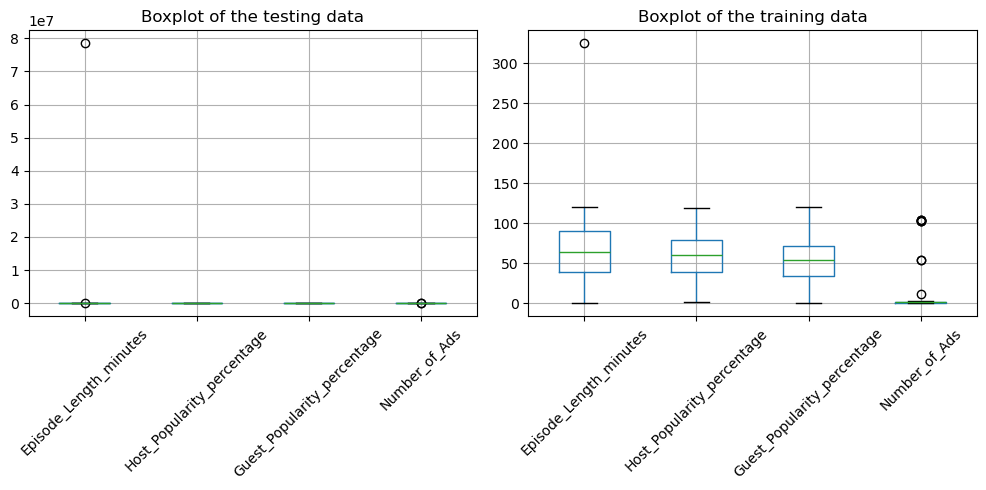

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
test[num_without_id].boxplot()
plt.xticks(rotation=45)
plt.title("Boxplot of the testing data")
plt.subplot(1,2,2)
train[num_without_id].boxplot()
plt.xticks(rotation=45)
plt.title("Boxplot of the training data")
plt.tight_layout()
plt.show()

In [ ]:
def skewed(data, columns):
    for col in columns:
        print(f"The skewness of the {col} is {data[col].skew()}")

In [ ]:
print('Training data')
skewed(train, num_without_id)
print('Testing data')
skewed(test, num_without_id)

Training data
The skewness of the Episode_Length_minutes is 0.00612298851900742
The skewness of the Host_Popularity_percentage is 0.004926275346942243
The skewness of the Guest_Popularity_percentage is -0.1503555626242561
The skewness of the Number_of_Ads is 6.032995851780484
Testing data
The skewness of the Episode_Length_minutes is 499.9999638772983
The skewness of the Host_Popularity_percentage is 0.011749553531104412
The skewness of the Guest_Popularity_percentage is -0.14875420913689333
The skewness of the Number_of_Ads is 448.86746290951714


[]

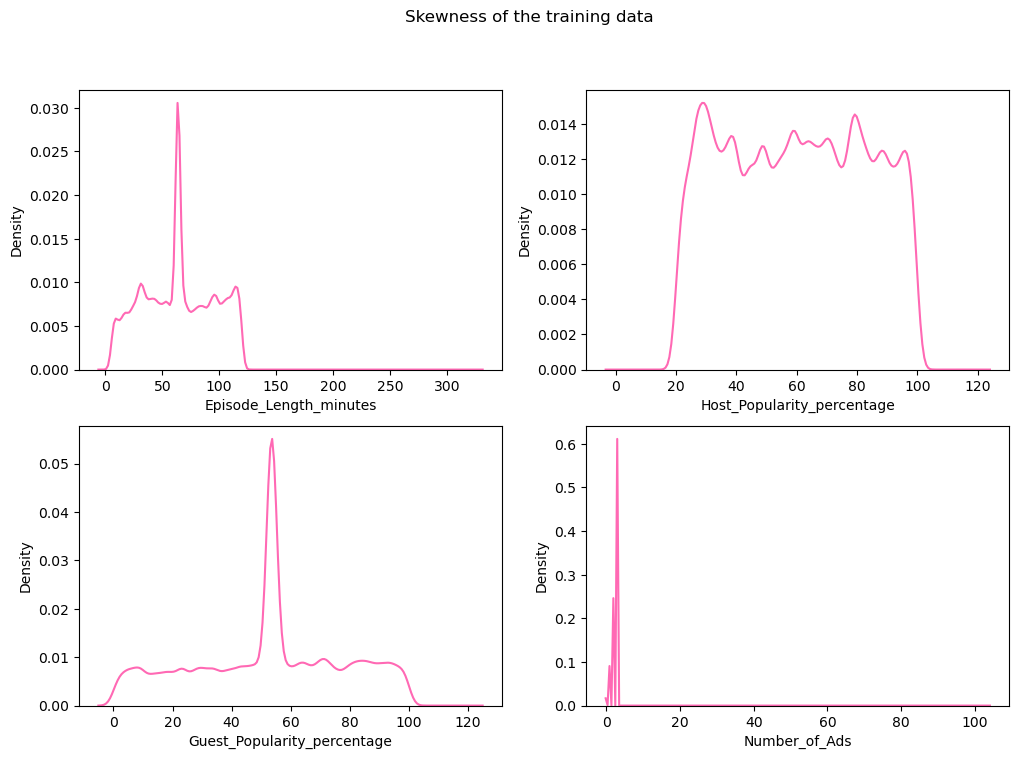

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
sns.kdeplot(train['Episode_Length_minutes'], ax=axes[0, 0], color='hotpink')
sns.kdeplot(train['Host_Popularity_percentage'], ax=axes[0, 1], color='hotpink')
sns.kdeplot(train['Guest_Popularity_percentage'], ax=axes[1, 0], color='hotpink')
sns.kdeplot(train['Number_of_Ads'], ax=axes[1, 1], color='hotpink')
fig.suptitle("Skewness of the training data")
plt.plot()

[]

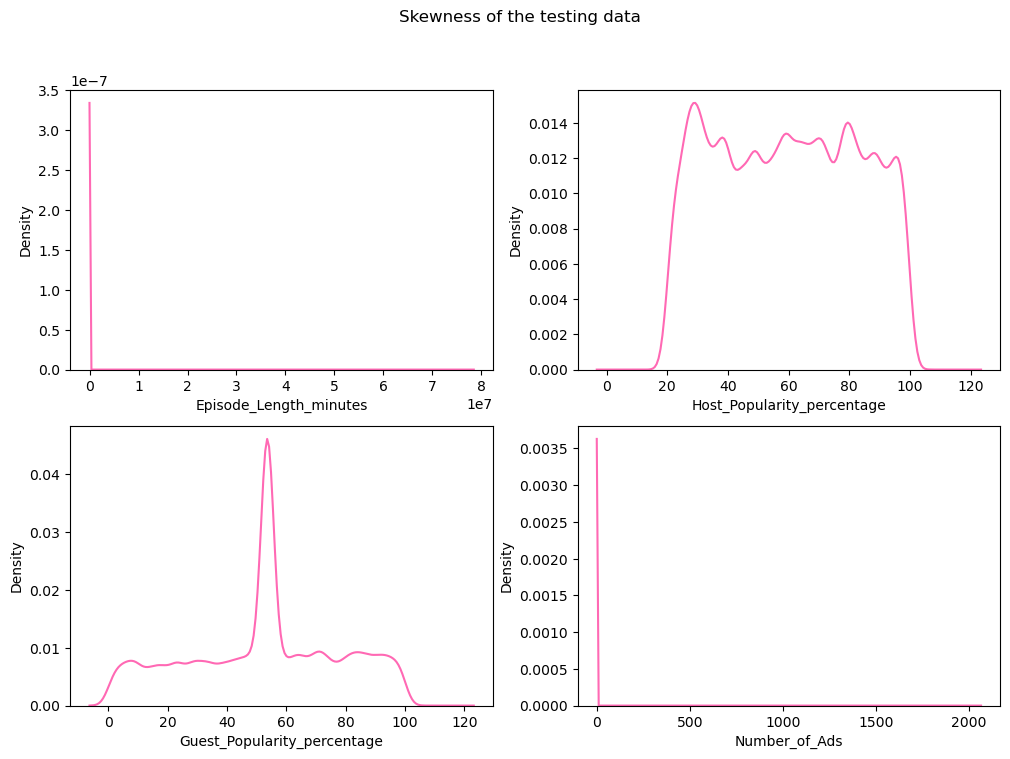

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
sns.kdeplot(test['Episode_Length_minutes'], ax=axes[0, 0], color='hotpink')
sns.kdeplot(test['Host_Popularity_percentage'], ax=axes[0, 1], color='hotpink')
sns.kdeplot(test['Guest_Popularity_percentage'], ax=axes[1, 0], color='hotpink')
sns.kdeplot(test['Number_of_Ads'], ax=axes[1, 1], color='hotpink')
fig.suptitle("Skewness of the testing data")
plt.plot()

**Insights:**
1. There is no such a big amount of outliers, but they are anomaly big, so it is important to deal with them
2. The `Guest_Popularity_percentage` and the `Host_Popularity_percentage` columns have very similar skewness both in training and testing data, they are close to the normal distribution
3. `Number_of_Abs` column is right-skewed in both data sets, but the testing set has much higher value of skew then the training set
4. `Episode_Length_minutes` is right-skewed in the testing data and has huge value of skew, but in the training data this column is close to the normal distribution

**Dealing with outliers**

Anomaly big values are not only in the training data, but also in testing, so it is important to deal with them not only in the training data.

**There are some values in columns with percentage that are higher then 100, so it is uncorrect**

In [ ]:
def replace(data, value_up, value_low, columns):
    data_copy = data.copy()
    for column in columns:
        up_mask = data_copy[column] > value_up
        if up_mask.any():
            data_copy.loc[up_mask, column] = value_up
            print(f"{column}: replaced {up_mask.sum()} values with {value_up}")
        low_mask = data_copy[column] < value_low
        if low_mask.any():
            data_copy.loc[low_mask, column] = value_low
            print(f"{column}: replaced {low_mask.sum()} values with {value_low}")
    return data_copy

In [ ]:
X_train = train[num_without_id]
X_test = test[num_without_id]
percentage_cols = ['Guest_Popularity_percentage', 'Host_Popularity_percentage']
X_train_replaced_percentage = replace(X_train, 100,0,percentage_cols)
X_test_replaced_percentage = replace(X_test, 100,0,percentage_cols)

Guest_Popularity_percentage: replaced 19 values with 100
Host_Popularity_percentage: replaced 25 values with 100
Guest_Popularity_percentage: replaced 5 values with 100
Host_Popularity_percentage: replaced 12 values with 100


In [ ]:
X_train_replaced_percentage[percentage_cols].describe()

,Guest_Popularity_percentage,Host_Popularity_percentage
count,750000.000000,750000.000000
mean,52.501680,59.859482
std,25.536766,22.872221
min,0.000000,1.300000
25%,34.550000,39.410000
50%,53.600000,60.050000
75%,71.040000,79.530000
max,100.000000,100.000000


In [ ]:
X_test_replaced_percentage[percentage_cols].describe()

,Guest_Popularity_percentage,Host_Popularity_percentage
count,250000.000000,250000.000000
mean,52.467371,59.716117
std,25.521647,22.879264
min,0.000000,2.490000
25%,34.550000,39.250000
50%,53.600000,59.900000
75%,70.990000,79.390000
max,100.000000,100.000000


In [ ]:
X_test = X_test_replaced_percentage
X_train = X_train_replaced_percentage

In [ ]:
def replace_outliers(train_data, test_data, columns):
    data_replaced_train = train_data.copy()
    data_replaced_test = test_data.copy()
    for column in columns:
        col_data_train = train_data[column]
        data_std = statistics.stdev(col_data_train)
        data_mean = statistics.mean(col_data_train)
        anomaly_cut_off = data_std * 3
        lower_limit = round(data_mean - anomaly_cut_off, 2)
        upper_limit = round(data_mean + anomaly_cut_off, 2)
        data_replaced_train = replace(data_replaced_train, upper_limit, lower_limit, [column])
        data_replaced_test = replace(data_replaced_test, upper_limit, lower_limit, [column])
    return data_replaced_train, data_replaced_test

In [ ]:
outlier_cols = ['Episode_Length_minutes', 'Number_of_Ads']
X_train_replaced, X_test_replaced = replace_outliers(X_train, X_test, outlier_cols)

Episode_Length_minutes: replaced 1 values with 157.41
Episode_Length_minutes: replaced 2 values with 157.41
Number_of_Ads: replaced 9 values with 4.8
Number_of_Ads: replaced 2 values with 4.8


In [ ]:
X_train_replaced = X_train_replaced.round({'Number_of_Ads':0})
X_test_replaced = X_test_replaced.round({'Number_of_Ads':0})

In [ ]:
X_train_replaced[outlier_cols].describe()

,Episode_Length_minutes,Number_of_Ads
count,750000.000000,750000.000000
mean,64.419194,1.347928
std,30.995881,1.111032
min,0.000000,0.000000
25%,39.420000,0.000000
50%,63.770000,1.000000
75%,90.310000,2.000000
max,157.410000,5.000000


In [ ]:
X_test_replaced[outlier_cols].describe()

,Episode_Length_minutes,Number_of_Ads
count,250000.000000,250000.000000
mean,64.458749,1.347284
std,31.003361,1.112713
min,2.470000,0.000000
25%,39.370000,0.000000
50%,63.770000,1.000000
75%,90.510000,2.000000
max,157.410000,5.000000


In [ ]:
X_test = X_test_replaced
X_train = X_train_replaced

**New value of skewness**

In [ ]:
print('Training data')
skewed(X_train, num_without_id)
print('Testing data')
skewed(X_test, num_without_id)

Training data
The skewness of the Episode_Length_minutes is 0.005386980199728367
The skewness of the Host_Popularity_percentage is 0.0047382817591158375
The skewness of the Guest_Popularity_percentage is -0.15047263685727844
The skewness of the Number_of_Ads is 0.21836520262894474
Testing data
The skewness of the Episode_Length_minutes is 0.004099249956181506
The skewness of the Host_Popularity_percentage is 0.011593305493045221
The skewness of the Guest_Popularity_percentage is -0.14889337644977307
The skewness of the Number_of_Ads is 0.21868805990274195


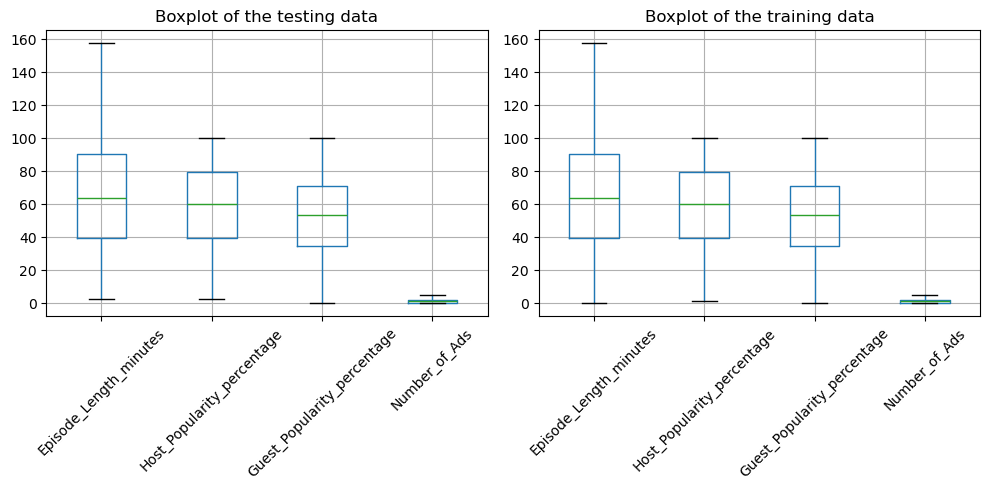

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
X_test.boxplot()
plt.xticks(rotation=45)
plt.title("Boxplot of the testing data")
plt.subplot(1,2,2)
X_train.boxplot()
plt.xticks(rotation=45)
plt.title("Boxplot of the training data")
plt.tight_layout()
plt.show()

[]

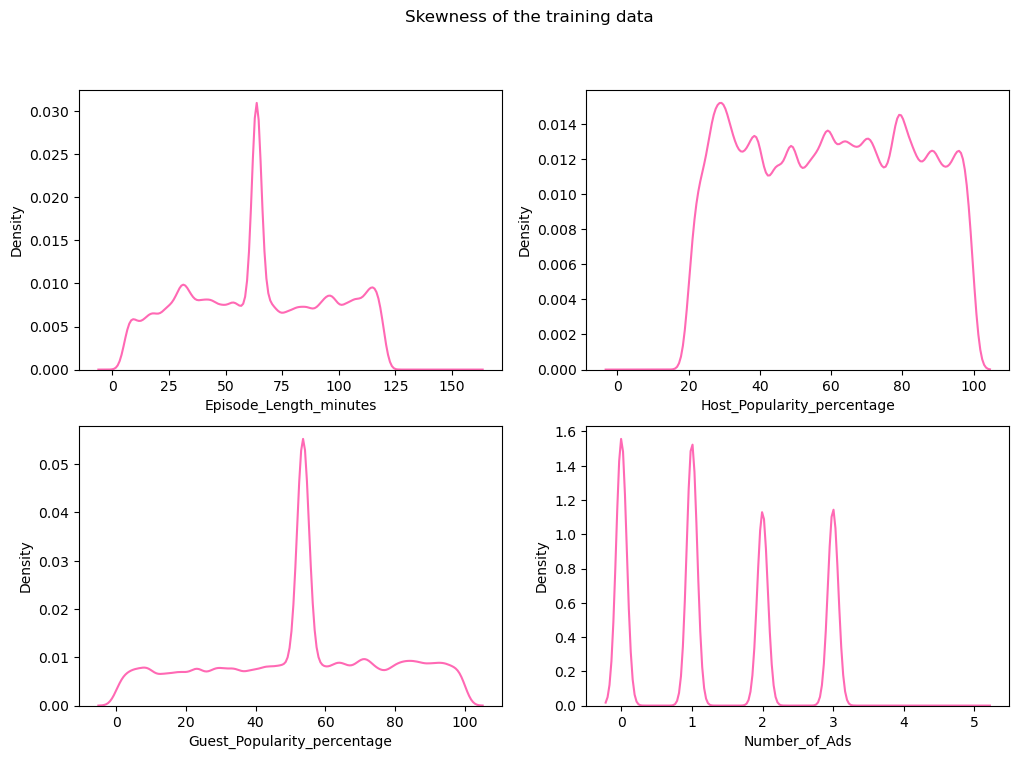

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
sns.kdeplot(X_train['Episode_Length_minutes'], ax=axes[0, 0], color='hotpink')
sns.kdeplot(X_train['Host_Popularity_percentage'], ax=axes[0, 1], color='hotpink')
sns.kdeplot(X_train['Guest_Popularity_percentage'], ax=axes[1, 0], color='hotpink')
sns.kdeplot(X_train['Number_of_Ads'], ax=axes[1, 1], color='hotpink')
fig.suptitle("Skewness of the training data")
plt.plot()

[]

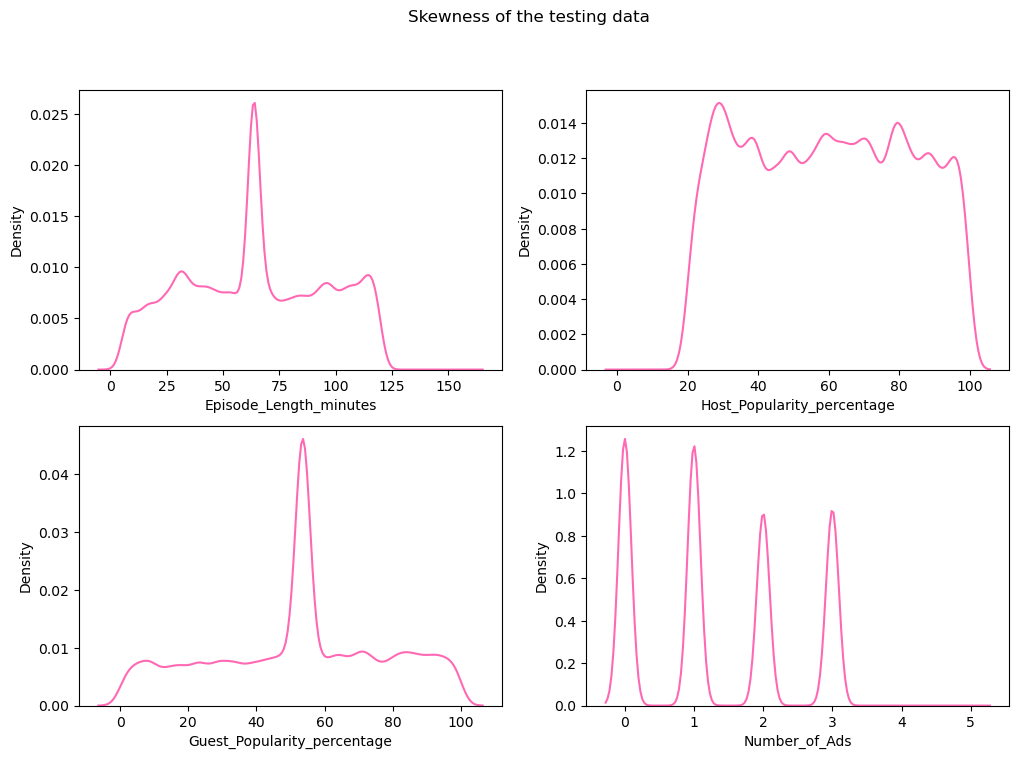

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
sns.kdeplot(X_test['Episode_Length_minutes'], ax=axes[0, 0], color='hotpink')
sns.kdeplot(X_test['Host_Popularity_percentage'], ax=axes[0, 1], color='hotpink')
sns.kdeplot(X_test['Guest_Popularity_percentage'], ax=axes[1, 0], color='hotpink')
sns.kdeplot(X_test['Number_of_Ads'], ax=axes[1, 1], color='hotpink')
fig.suptitle("Skewness of the testing data")
plt.plot()

**Insights:**
- Now the data isn't contain any anomaly huge values, so it is clean and all columns are close to the normal distribution.

**5.Feature Scaling**
--

In [ ]:
episode_completion = train.groupby('Podcast_Name')['Episode_Title'].nunique()
print(episode_completion)

Podcast_Name
Athlete's Arena        100
Brain Boost            100
Business Briefs        100
Business Insights      100
Comedy Corner          100
Crime Chronicles       100
Criminal Minds         100
Current Affairs        100
Daily Digest           100
Detective Diaries      100
Digital Digest         100
Educational Nuggets    100
Fashion Forward        100
Finance Focus          100
Fitness First          100
Funny Folks            100
Gadget Geek            100
Game Day               100
Global News            100
Health Hour            100
Healthy Living         100
Home & Living          100
Humor Hub              100
Innovators             100
Joke Junction          100
Laugh Line             100
Learning Lab           100
Life Lessons           100
Lifestyle Lounge       100
Market Masters         100
Melody Mix             100
Mind & Body            100
Money Matters          100
Music Matters          100
Mystery Matters        100
News Roundup           100
Sound Waves    

In [ ]:
episode_completion_test = test.groupby('Podcast_Name')['Episode_Title'].nunique()
print(episode_completion_test)

Podcast_Name
Athlete's Arena        100
Brain Boost            100
Business Briefs        100
Business Insights      100
Comedy Corner          100
Crime Chronicles       100
Criminal Minds         100
Current Affairs        100
Daily Digest           100
Detective Diaries      100
Digital Digest         100
Educational Nuggets    100
Fashion Forward        100
Finance Focus          100
Fitness First          100
Funny Folks            100
Gadget Geek            100
Game Day               100
Global News            100
Health Hour            100
Healthy Living         100
Home & Living          100
Humor Hub              100
Innovators             100
Joke Junction          100
Laugh Line             100
Learning Lab           100
Life Lessons           100
Lifestyle Lounge       100
Market Masters         100
Melody Mix             100
Mind & Body            100
Money Matters          100
Music Matters          100
Mystery Matters        100
News Roundup           100
Sound Waves    

**That means that all podcasts have 100 episodes**

**All episodes have names like this 'Episode_Number', so we can convert this column into numerical**

In [ ]:
X_train['Episode_Title'] = train['Episode_Title'].str.extract('(\d+)').astype(int)
X_train['Episode_Title'].head()
X_test['Episode_Title'] = test['Episode_Title'].str.extract('(\d+)').astype(int)
X_test['Episode_Title'].head()

0    73
1    23
2    11
3    73
4    50
Name: Episode_Title, dtype: int64

**As now we have clean data without outliers and distribution very close to normal, then we can use StandardScaler**

In [ ]:
scaler = StandardScaler().fit(X_train)

In [ ]:
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [ ]:
X_scaled_train

array([[-0.02094453,  0.65365439,  0.04300941, -1.21322191,  1.65758193],
       [ 1.78671621,  0.31000585,  0.91821871,  0.58690675, -0.90600903],
       [ 0.3058733 ,  0.44204384, -1.70466805, -1.21322191, -1.26206333],
       ...,
       [-1.07882774,  0.81848326,  1.26830243, -1.21322191, -0.01587328],
       [ 1.43763734, -0.63262295,  1.59645697, -1.21322191, -0.158295  ],
       [-1.30079286, -1.63558699, -0.61799878, -1.21322191,  1.69318736]])

In [ ]:
X_scaled_test

array([[ 0.46912091, -0.95091319,  0.03243641, -0.31315758,  0.76744618],
       [-1.17916372,  0.49975581,  0.04300941, -1.21322191, -1.01282532],
       [ 0.15101391,  0.35110377,  1.7624922 , -1.21322191, -1.44009048],
       ...,
       [-1.68761871, -1.48387447,  0.8297188 , -0.31315758,  0.41139188],
       [ 1.58217277, -0.71656763,  1.60898793,  1.48697107, -0.19390043],
       [ 0.43976215, -0.79307971, -0.06781128, -1.21322191, -0.19390043]])

In [ ]:
train[X_train.columns] = X_scaled_train
test[X_test.columns] = X_scaled_test

In [ ]:
train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,1.657582,-0.020945,True Crime,0.653654,Thursday,Night,0.043009,-1.213222,Positive,31.41998
1,1,Joke Junction,-0.906009,1.786716,Comedy,0.310006,Saturday,Afternoon,0.918219,0.586907,Negative,88.01241
2,2,Study Sessions,-1.262063,0.305873,Education,0.442044,Tuesday,Evening,-1.704668,-1.213222,Negative,44.92531
3,3,Digital Digest,-0.229506,0.088748,Technology,-0.115401,Monday,Morning,1.025907,0.586907,Positive,46.27824
4,4,Mind & Body,1.230317,1.486999,Health,0.883628,Monday,Afternoon,0.241938,1.486971,Neutral,75.61031


In [ ]:
test.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,0.767446,0.469121,Education,-0.950913,Saturday,Evening,0.032436,-0.313158,Neutral
1,750001,Sound Waves,-1.012825,-1.179164,Music,0.499756,Sunday,Morning,0.043009,-1.213222,Neutral
2,750002,Joke Junction,-1.440090,0.151014,Comedy,0.351104,Friday,Evening,1.762492,-1.213222,Positive
3,750003,Comedy Corner,0.767446,1.644439,Comedy,-1.594052,Sunday,Morning,-0.029435,0.586907,Positive
4,750004,Life Lessons,-0.051479,0.254899,Lifestyle,-0.076927,Wednesday,Morning,-1.613427,0.586907,Neutral


**6. Data Visualization and Correlation Analysis**
--

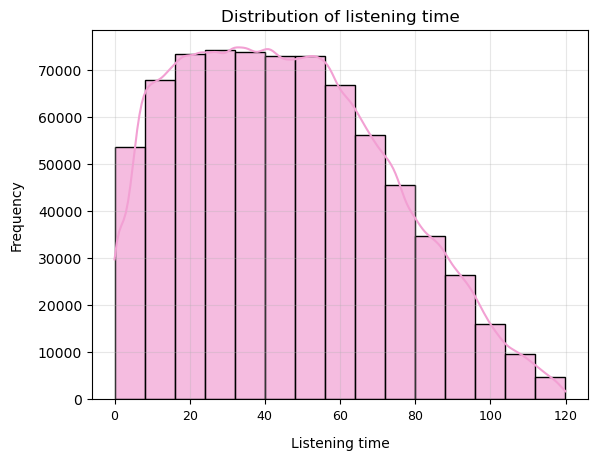

In [ ]:
sns.histplot(train['Listening_Time_minutes'], bins=15, alpha=0.7, edgecolor='black', color='#F2A0D3', kde=True)
plt.xlabel('Listening time', labelpad=10)
plt.ylabel('Frequency', labelpad=10)
plt.xticks(fontsize=9)
plt.title('Distribution of listening time')
plt.grid(True, alpha=0.3)
plt.show()

**Insights:**
- The most popular listening time is around 20 and 50 minutes. 
- As listening time increases, the frequency gradually declines.
- The KDE is shifted to the left, meaning that users usually don't listen for very long.

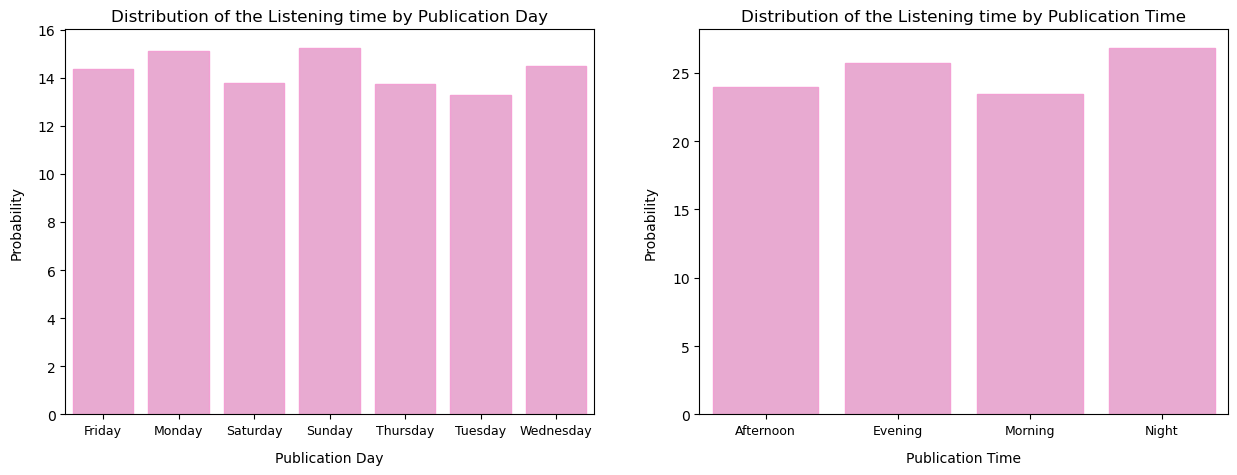

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
train_listening_publication_day = train.groupby("Publication_Day")['Listening_Time_minutes'].sum()
train_listening_publication_day_prob = train_listening_publication_day / train_listening_publication_day.sum() *100
sns.barplot(x=train_listening_publication_day_prob.index, y=train_listening_publication_day_prob.values, color="#F2A0D3", edgecolor="#F2A0D3")
plt.xlabel('Publication Day', labelpad=10)
plt.ylabel('Probability', labelpad=10)
plt.xticks(fontsize=9)
plt.title('Distribution of the Listening time by Publication Day')

plt.subplot(1, 2, 2)
train_listening_publication_time = train.groupby("Publication_Time")['Listening_Time_minutes'].sum()
train_listening_publication_time_prob = train_listening_publication_time / train_listening_publication_time.sum() * 100
sns.barplot(x=train_listening_publication_time_prob.index, y=train_listening_publication_time_prob.values, color="#F2A0D3", edgecolor="#F2A0D3")
plt.xlabel('Publication Time', labelpad=10)
plt.ylabel('Probability', labelpad=10)
plt.xticks(fontsize=9)
plt.title('Distribution of the Listening time by Publication Time')
plt.show()

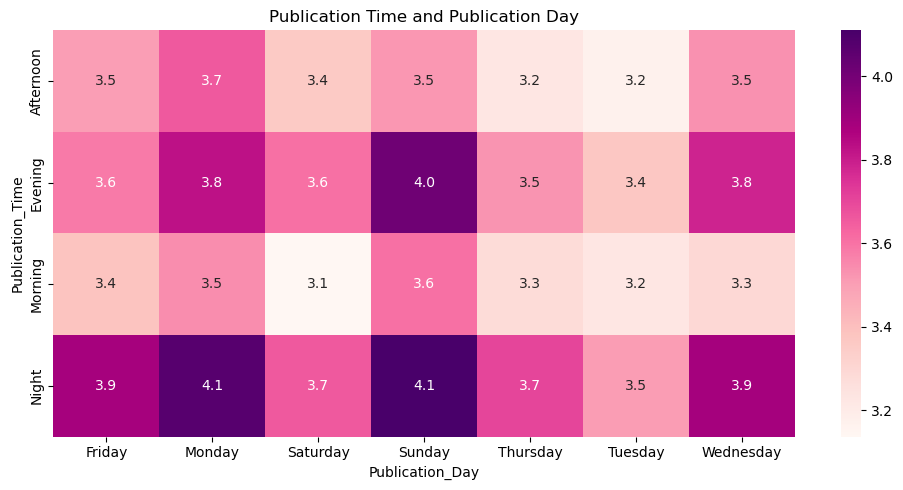

In [ ]:
plt.figure(figsize=(10, 5))
cross_tab = pd.crosstab(train['Publication_Time'], train['Publication_Day'], aggfunc='sum', values=train['Listening_Time_minutes'], normalize=True)
sns.heatmap(cross_tab * 100, annot=True, fmt=".1f", cmap='RdPu')
plt.title("Publication Time and Publication Day")
plt.tight_layout()
plt.show()

**Insights:**
1. There are no significant differences and dependences between the distributions by specific days of the week and publication times, but the highest values ​​are observed on Mondays and Sundays, as well as at night and in the evening.
2. The most active time is Sunday Nights and Evenings and Moday Nights.

In [ ]:
selected_features = ['Episode_Length_minutes', 'Host_Popularity_percentage', 
                     'Guest_Popularity_percentage', 'Number_of_Ads', 'Listening_Time_minutes', 'Episode_Title']

<Figure size 2500x2500 with 0 Axes>

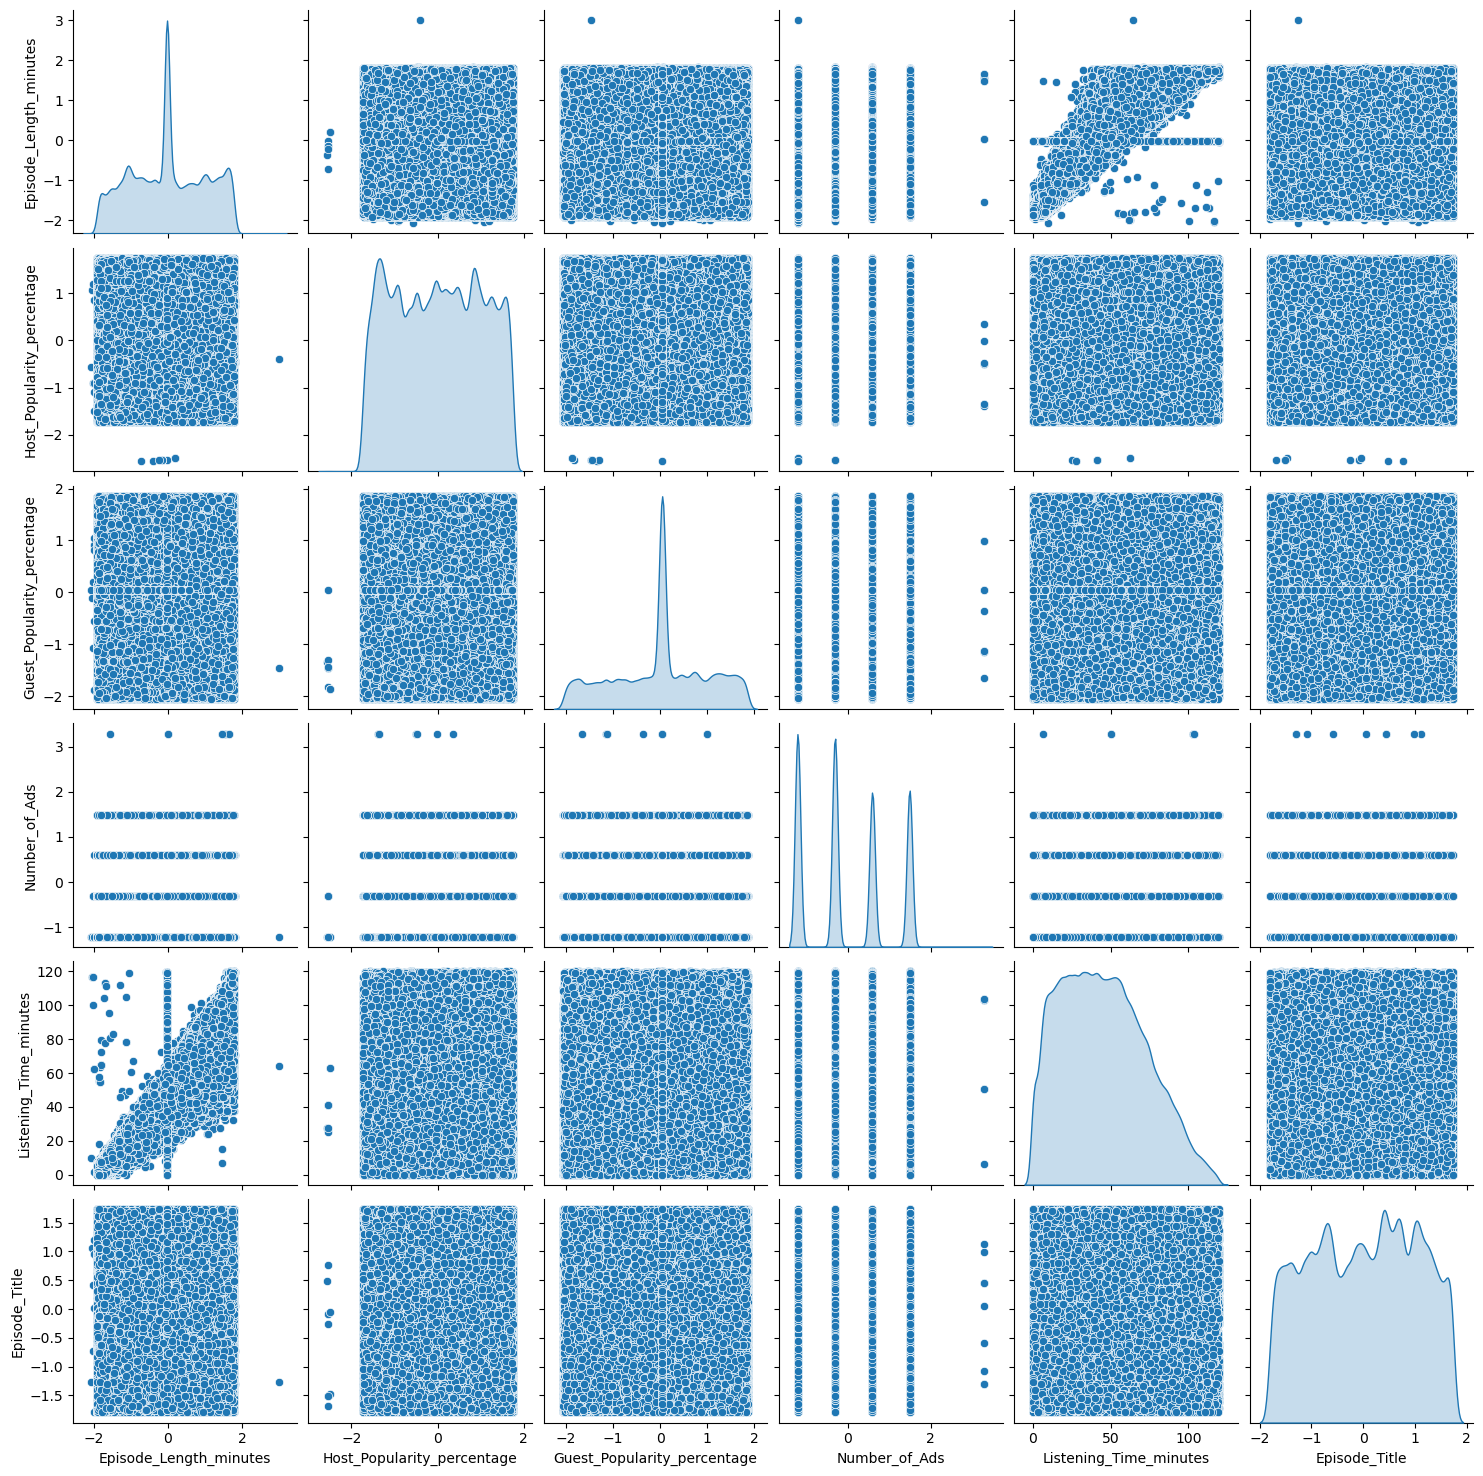

In [ ]:
plt.figure(figsize=(25,25))
sns.pairplot(train[selected_features], diag_kind='kde')
plt.show()

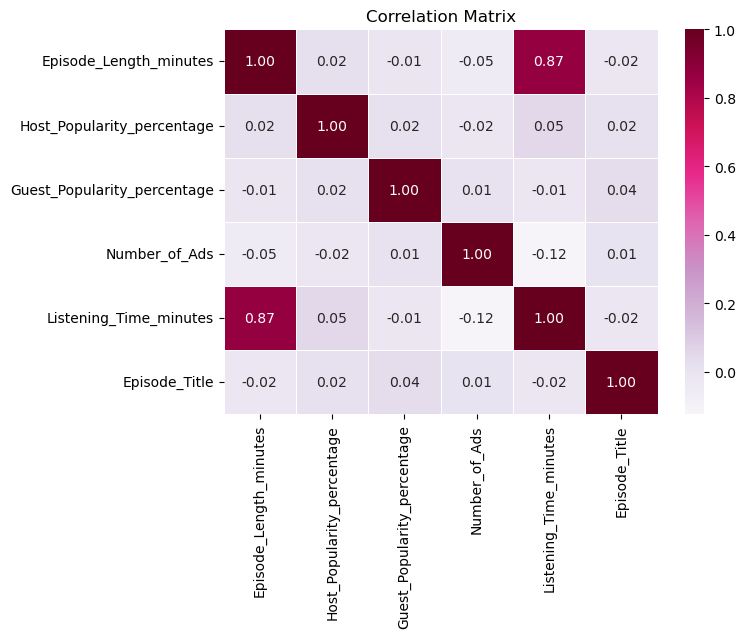

In [ ]:
corr_matrix_train = train[selected_features].corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr_matrix_train, annot=True, cmap="PuRd", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

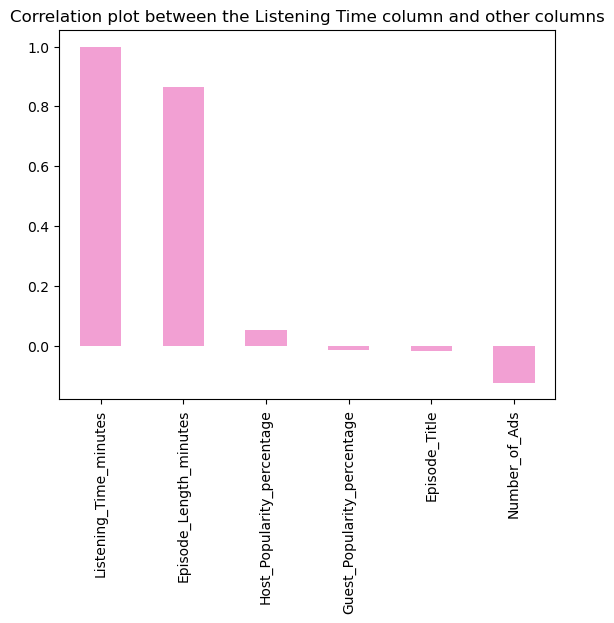

In [ ]:
corr_matrix_train['Listening_Time_minutes'].sort_values(ascending=False).plot(kind='bar', color='#F2A0D3')
plt.title("Correlation plot between the Listening Time column and other columns")
plt.show()

**Insights:**
- There is a strong positive correlation between `Episode_Length_minutes` and `Listening_Time_minutes` (0.87)
- Between `Number_of_Ads` and `Listening_Time_minutes` there is a negative correlation (-0.12)
- Other variables have correlations with `Listening_Time_minutes` approximately 0, so they are not so significant

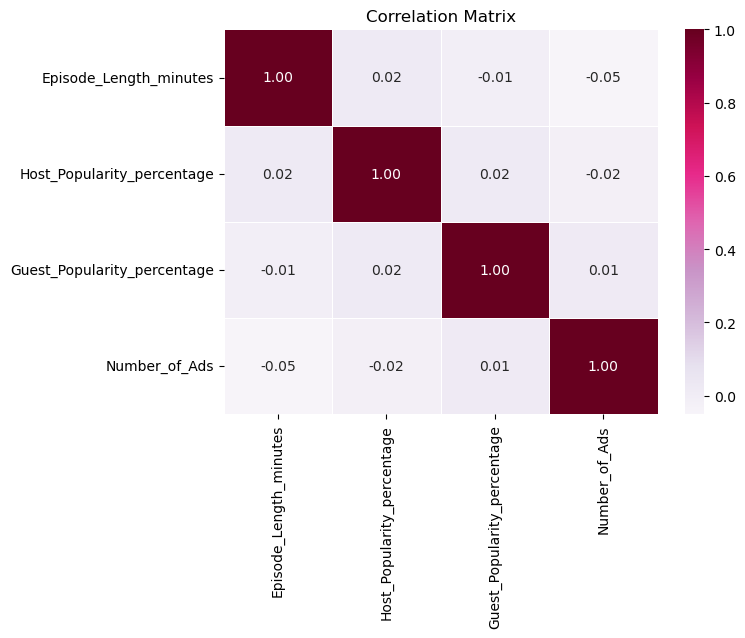

In [ ]:
corr_matrix = test[num_without_id].corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr_matrix, annot=True, cmap="PuRd", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

**Number of Ads**

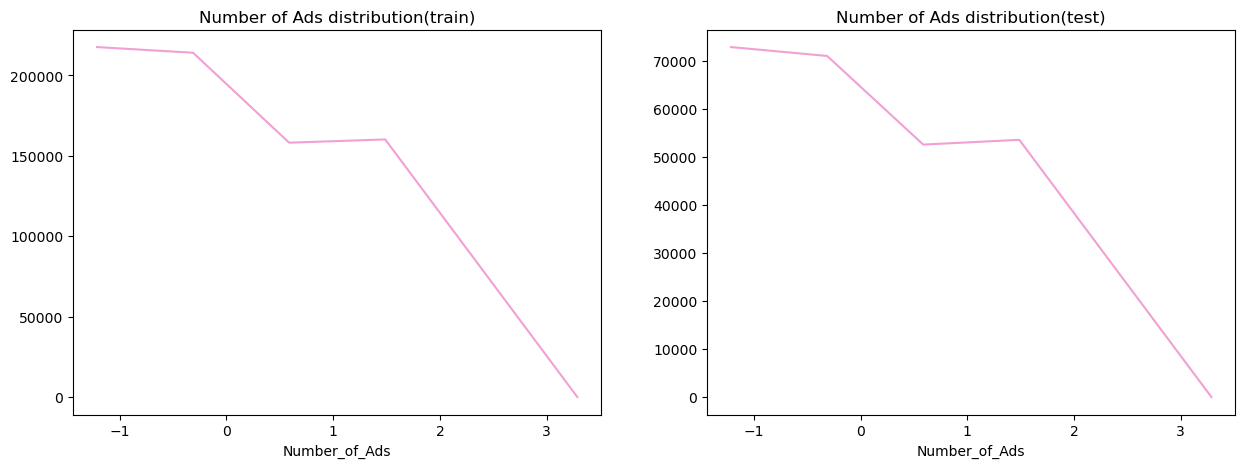

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Number of Ads distribution(train)")
train['Number_of_Ads'].value_counts().sort_index(ascending=True).plot(color='#F2A0D3')
plt.subplot(1,2,2)
test['Number_of_Ads'].value_counts().sort_index(ascending=True).plot(color='#F2A0D3')
plt.title("Number of Ads distribution(test)")
plt.show()

**Insights:**

- Most podcasts contain few ads.

- There are a small number of podcasts with very high numbers of ads, which form the long tail on the right.

- The distribution of the column `Number_of_Ads` is left-skewed and is similar for both training and testing set


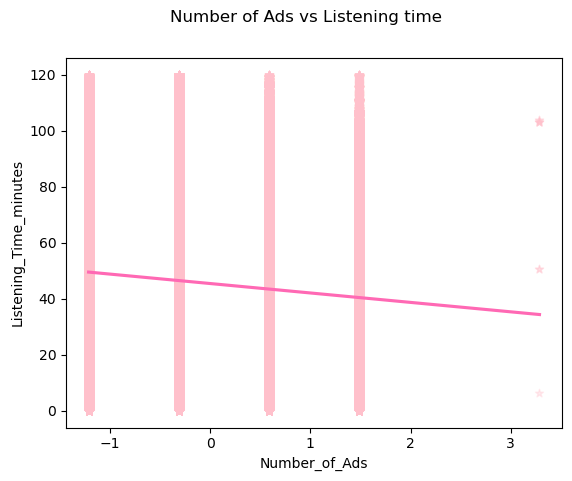

In [ ]:
sns.regplot(data=train, x='Number_of_Ads', y='Listening_Time_minutes', line_kws={"color": "hotpink"}, color='pink', marker="*", scatter_kws={'alpha': 0.3})
plt.suptitle("Number of Ads vs Listening time")
plt.show()

**Insights:**
- As Number_of_Ads is increasing, the listening time is slightly decreasing

**Episode Length**

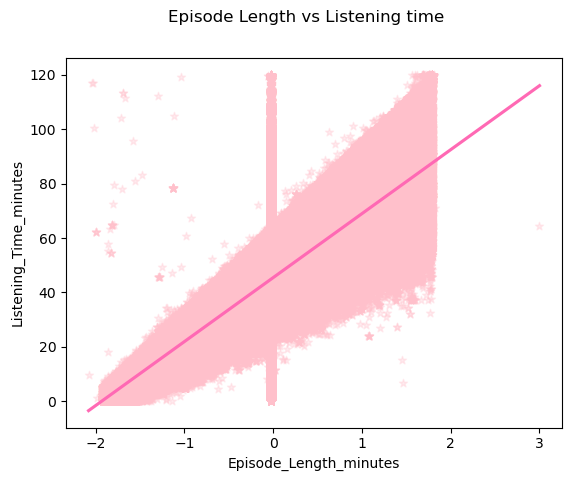

In [ ]:
sns.regplot(data=train, x='Episode_Length_minutes', y='Listening_Time_minutes', line_kws={"color": "hotpink"}, color='pink', marker="*", scatter_kws={'alpha': 0.3})
plt.suptitle("Episode Length vs Listening time")
plt.show()

**Insights:**
- As Episode Length is increasing, Listening time is increasing too

**There is very low correlation between `Host_Popularity_percentage`, `Guest_Popularity_percentage` and `Listening_Time_minutes`, so it is important to try to combine those features or add some new based on them**

In [ ]:
train_copy = train.copy()
train_copy['Host_Guest_Combo'] = train_copy['Host_Popularity_percentage'] * train_copy['Guest_Popularity_percentage']
train_copy[['Host_Guest_Combo', 'Listening_Time_minutes']].corr()

,Host_Guest_Combo,Listening_Time_minutes
Host_Guest_Combo,1.000000,0.001743
Listening_Time_minutes,0.001743,1.000000


In [ ]:
train_copy['Popularity_Balance'] = (train_copy['Host_Popularity_percentage'] - train_copy['Guest_Popularity_percentage']).abs()
train_copy[['Popularity_Balance', 'Listening_Time_minutes']].corr()

,Popularity_Balance,Listening_Time_minutes
Popularity_Balance,1.000000,0.021938
Listening_Time_minutes,0.021938,1.000000


In [ ]:
train_copy['Popularity_Avg'] = (train_copy['Host_Popularity_percentage'] + train_copy['Guest_Popularity_percentage']) / 2
train_copy[['Popularity_Avg', 'Listening_Time_minutes']].corr()

,Popularity_Avg,Listening_Time_minutes
Popularity_Avg,1.000000,0.025487
Listening_Time_minutes,0.025487,1.000000


In [ ]:
genre_host_avg = train_copy.groupby('Genre')['Host_Popularity_percentage'].mean()
genre_guest_avg = train_copy.groupby('Genre')['Guest_Popularity_percentage'].mean()

train_copy['Host_Guest_Above_Genre'] = (train_copy['Host_Popularity_percentage'] > train_copy['Genre'].map(genre_host_avg)).astype(int)
train_copy['Guest_Above_Genre'] = (train_copy['Guest_Popularity_percentage'] > train_copy['Genre'].map(genre_guest_avg)).astype(int)
train_copy[['Host_Guest_Above_Genre', 'Guest_Above_Genre', 'Listening_Time_minutes']].corr()

,Host_Guest_Above_Genre,Guest_Above_Genre,Listening_Time_minutes
Host_Guest_Above_Genre,1.000000,0.027037,0.042846
Guest_Above_Genre,0.027037,1.000000,-0.006586
Listening_Time_minutes,0.042846,-0.006586,1.000000


In [ ]:
train_copy['Ads_per_Popularity'] = train_copy['Number_of_Ads'] / (train_copy['Host_Popularity_percentage'] + 0.1)
train_copy[['Ads_per_Popularity', 'Listening_Time_minutes']].corr()

,Ads_per_Popularity,Listening_Time_minutes
Ads_per_Popularity,1.000000,-0.002187
Listening_Time_minutes,-0.002187,1.000000


In [ ]:
median_host = train_copy['Host_Popularity_percentage'].median()
median_guest = train_copy['Host_Popularity_percentage'].median()
train_copy['Popular'] = ((train_copy['Host_Popularity_percentage'] > median_host) | (train_copy['Guest_Popularity_percentage'] > median_guest)).astype(int)

train_copy['Host_Dominates'] = (train_copy['Host_Popularity_percentage'] > train_copy['Guest_Popularity_percentage']).astype(int)
train_copy[['Host_Dominates', 'Listening_Time_minutes', 'Popular']].corr()

,Host_Dominates,Listening_Time_minutes,Popular
Host_Dominates,1.000000,0.039199,-0.051244
Listening_Time_minutes,0.039199,1.000000,0.016665
Popular,-0.051244,0.016665,1.000000


**Those combinations are not really helpful**

In [ ]:
train_copy['Length_Popularity_Interaction'] = train_copy['Episode_Length_minutes'] * (train_copy['Host_Popularity_percentage']+train_copy['Guest_Popularity_percentage'])
train_copy['Length_Ads_Ratio'] = train_copy['Episode_Length_minutes'] / (train_copy['Number_of_Ads'] + 1)
train_copy[['Length_Popularity_Interaction','Length_Ads_Ratio' ,'Listening_Time_minutes']].corr()

,Length_Popularity_Interaction,Length_Ads_Ratio,Listening_Time_minutes
Length_Popularity_Interaction,1.000000,0.003351,0.0129
Length_Ads_Ratio,0.003351,1.000000,-0.2432
Listening_Time_minutes,0.012900,-0.243200,1.0000


The correlation between `Length_Ads_Ratio` and `Listening_Time_minutes` is negative(-0.24), that means if `Length_Ads_Ratio` increases, `Listening_Time_minutes` decreases.This feature can be useful, so we can add to the main dataset.

In [ ]:
train['Length_Ads_Ratio'] = train['Episode_Length_minutes'] / (train['Number_of_Ads'] + 1)
test['Length_Ads_Ratio'] = test['Episode_Length_minutes'] / (test['Number_of_Ads'] + 1)

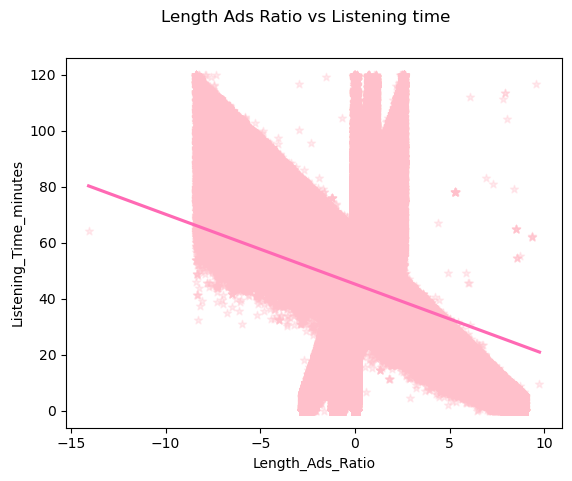

In [ ]:
sns.regplot(data=train, x='Length_Ads_Ratio', y='Listening_Time_minutes', line_kws={"color": "hotpink"}, color='pink', marker="*", scatter_kws={'alpha': 0.3})
plt.suptitle("Length Ads Ratio vs Listening time")
plt.show()

**Exploration of categorical columns**

In [ ]:
explored_train_cat = train[cat_features]
explored_test_cat = test[cat_features]

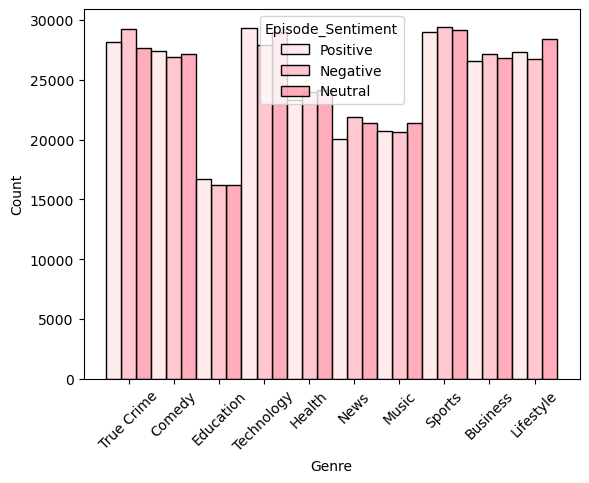

In [ ]:
sns.histplot(x='Genre', hue='Episode_Sentiment', data=explored_train_cat, stat='count', multiple='dodge', palette=['#FFE4E6', '#FFB6C1', '#FF91A4'])
plt.xticks(rotation=45)
plt.show()

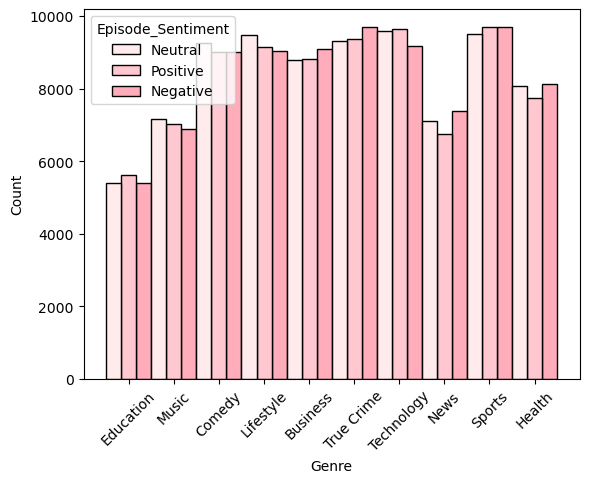

In [ ]:
sns.histplot(x='Genre', hue='Episode_Sentiment', data=explored_test_cat, stat='count', multiple='dodge', palette=['#FFE4E6', '#FFB6C1', '#FF91A4'])
plt.xticks(rotation=45)
plt.show()

`Episode_Sentiment`:
- The distribution is almost uniform in this column in both training and testing datasets

`Genre`:
- The distribution of the `genre` column in the training set differs slightly from that in the test set, but in both sets, the least popular genres are Education, News, and Music.

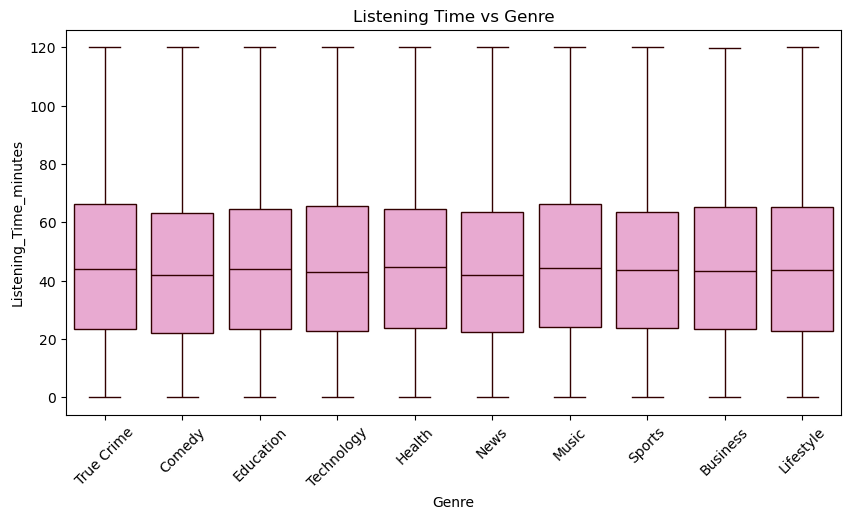

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=train, x='Genre', y='Listening_Time_minutes', color="#F2A0D3", linecolor="#320000")
plt.title('Listening Time vs Genre')
plt.xticks(rotation=45)
plt.show()

**Insights:**
- All genres show roughly the same listening time.
- Medians are within a very narrow range.
- There are no clear leaders or losers.
- Genre is not a determining factor in listening time.
- Audiences listen to podcasts regardless of topic.

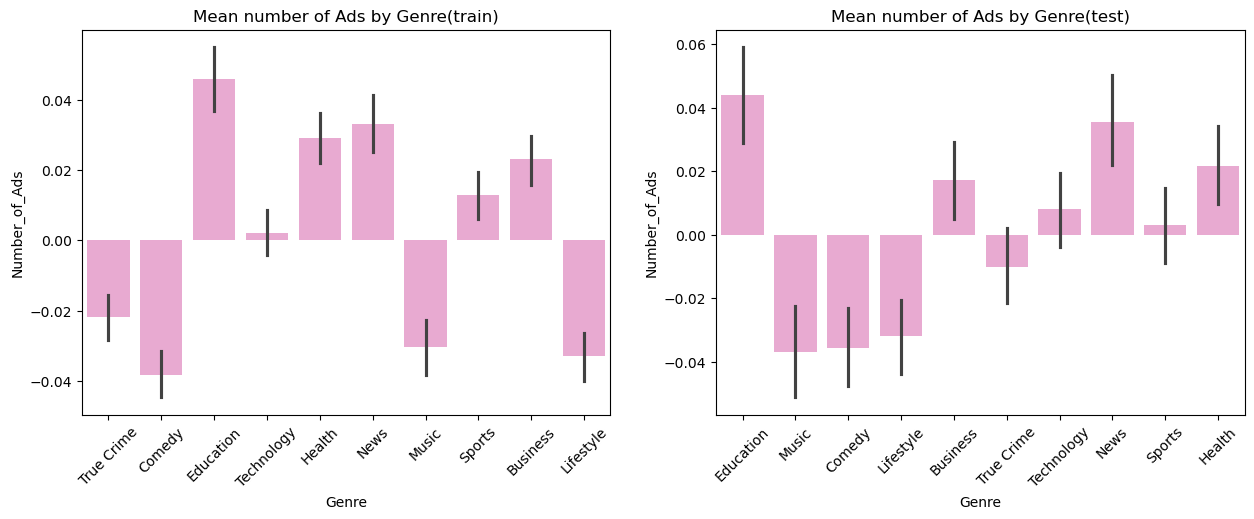

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.barplot(data=train, x='Genre', y='Number_of_Ads', color='#F2A0D3')
plt.title('Mean number of Ads by Genre(train)')
plt.xticks(rotation=45)
plt.subplot(1,2,2)
sns.barplot(data=test, x='Genre', y='Number_of_Ads', color='#F2A0D3')
plt.title('Mean number of Ads by Genre(test)')
plt.xticks(rotation=45)
plt.show()

**Insights:**
- Technology genre: maximum engagement with minimal advertising.
- True Crime/Comedy - lots of advertising, but average engagement
- Sports/Music - few ads + low engagement

In [ ]:
avg_lengths = train_copy.groupby('Podcast_Name')['Episode_Length_minutes'].mean().round(2)
train_copy['Avg_Episode_Length'] = train_copy['Podcast_Name'].map(avg_lengths)
new_corr_m = train_copy[['Avg_Episode_Length', 'Listening_Time_minutes']].corr()
new_corr_m


,Avg_Episode_Length,Listening_Time_minutes
Avg_Episode_Length,1.00000,0.04804
Listening_Time_minutes,0.04804,1.00000


**The feature `Avg_Episode_Length` has very small value of correlation with `Listening_Time_minutes`, so it doesn't help much if adding this new feature.**

In [ ]:
correlation_with_target = train.corr(numeric_only=True)['Listening_Time_minutes'].abs()
low_corr_columns = correlation_with_target[correlation_with_target < 0.1].index.tolist()
low_corr_columns = [col for col in low_corr_columns if col != 'Listening_Time_minutes']

print(f"Columns with correlation less then 0.1 would be deleted: {len(low_corr_columns)}")
print(low_corr_columns)

train_reduced = train.drop(columns=low_corr_columns)
test_reduced = test.drop(columns=low_corr_columns)

print(train.shape[1])
print(train_reduced.shape[1])

Columns with correlation less then 0.1 would be deleted: 4
['id', 'Episode_Title', 'Host_Popularity_percentage', 'Guest_Popularity_percentage']
13
9


In [ ]:
test = test_reduced
train = train_reduced

**7. General Observations and Summary**
--

1. There were big amount of nullable values, so I choose and applied the best imputer (Simple Imputer)
2. I have converted column `Episode_Title` into numerical one
3. There were some very huge outliers, so I cleaned the data
4. In columns with percentage there were some values that are bigger then 100, I have replaced them with 100
5. I have applied feature scaling (Standard Scaler)
6. The most important numerical columns in our data set are `Episode_Length_minutes` and `Number_of_Ads`. It is also important to add column `Length_Ads_Ratio`
7. The training set and the testing set have a similar distribution based on metrics, which significantly improves analysis and prediction
8. I have deleted columns that haven't big influence into `Listening_Time_minutes` column